# ising dynamics in dimension two

of course, following: http://bit-player.org/2021/three-months-in-monte-carlo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import ipywidgets as widgets
import importlib
import sys

In [2]:
ls

drive/  sample_data/


In [3]:
filehandle_ebgfn = 'drive/Othercomputers/numac/GitHub/EB_GFN/'
sys.path.insert(0, filehandle_ebgfn)

In [4]:
import ising_utils
importlib.reload(ising_utils)

<module 'ising_utils' from '/content/drive/Othercomputers/numac/GitHub/EB_GFN/ising_utils.py'>

Metropolis and Glauber dynamics both rely on two main components: a visitation sequence and an acceptance function.

For now, we focus on the acceptance function.

The acceptance function takes in a spin $s_v$ on the lattice, associated to some vertex $v \in V$.

1. Calculate $\Delta E$, the change in energy that would result from flipping selected spin $s$. To determine this value, we need to examine $s$ itself and its four nearest neighbors.

2. Based on $\Delta E$ and the temperature $T$, calculate the probability $p$ of flipping spin $s$.

3. Generate a random number $r$ in the interval $[0,1)$. If $r < p$, flip the selected spin; otherwise leave it as is.

Part 2 of the acceptance rule calls for a mathematical function that maps values of $\Delta E$ and $T$ to a probability $p$.

This function should:
1. assign a higher probability to spin flips that reduce the system's energy, and
2. the system preference for negative $\Delta E$ should grow sharper as $T$ gets lower

The Glauber acceptance function is:

$$
p =
\frac{e^{-\Delta E /T}}
{1 + e^{-\Delta E /T}}
$$

Note that these are [Fermi-Dirac statistics](https://en.wikipedia.org/wiki/Fermi%E2%80%93Dirac_statistics).

In [5]:
def glauber_acceptance(delta_E, T):
    """Glauber acceptance function."""
    return np.exp(-delta_E / T) / (1 + np.exp(-delta_E / T))

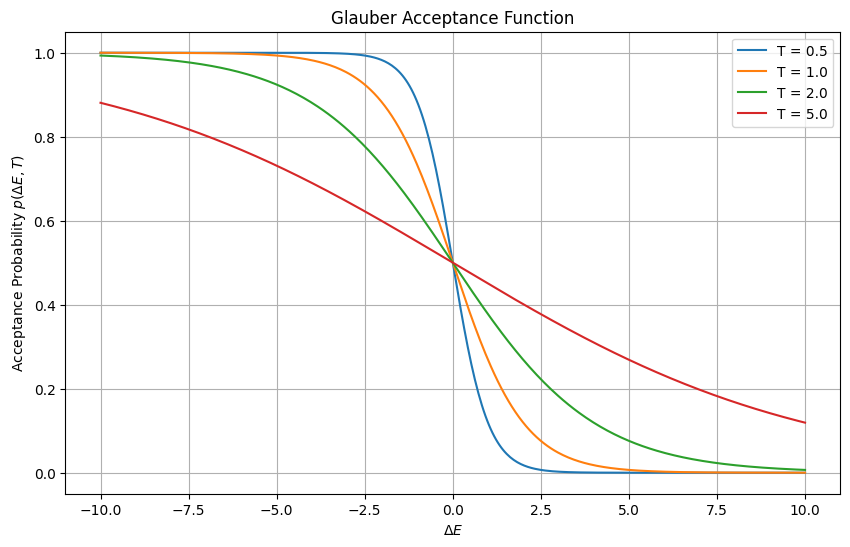

In [6]:
importlib.reload(ising_utils)
ising_utils.plot_glauber_acceptance()

The metropolis acceptance function is:

$$
p =
\begin{cases}
1 & \text{ if } \Delta E \leq 0 \\
e^{-\Delta E/T} & \text{ if } \Delta E > 0
\end{cases}
$$

In [7]:
def metropolis_acceptance(delta_E, T):
    """Metropolis acceptance function."""
    return np.where(delta_E <= 0, 1, np.exp(-delta_E / T))

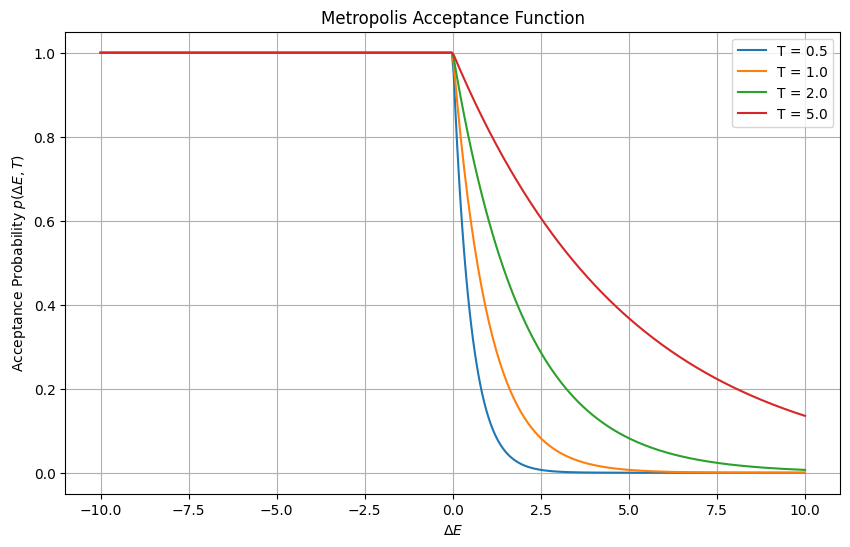

In [8]:
importlib.reload(ising_utils)
ising_utils.plot_metroplis_acceptance()

### **_Set simulation params_**

In [9]:
# Parameters
N = 10          # Lattice size
beta = 0.2      # Inverse temperature, estimated critical inverse temp. on square lattice is .44, so .4 corresponds to temp. slightly above critical
steps = 100   # Number of steps

### **_Glauber dynamics_**

In [10]:
# Initialize and simulate
importlib.reload(ising_utils)
lattice = ising_utils.initialize_lattice(N)
snapshots_glauber = ising_utils.simulate_glauber_interactive(lattice, beta, steps)

In [11]:
# Create interactive plot
interact(ising_utils.plot_lattice,
         lattice=widgets.fixed(snapshots_glauber),
         step=IntSlider(min=0,
                        max=len(snapshots_glauber)-1,
                        step=1,
                        value=0))

interactive(children=(IntSlider(value=0, description='step'), Output()), _dom_classes=('widget-interact',))

<function ising_utils.plot_lattice(lattice, step)>

### **_Metropolis dynamics_**

In [12]:
# Initialize and simulate
importlib.reload(ising_utils)
lattice = ising_utils.initialize_lattice(N)
snapshots_metropolis = ising_utils.simulate_metropolis_interactive(lattice, beta, steps)

In [13]:
# Create interactive plot
interact(ising_utils.plot_lattice,
         lattice=widgets.fixed(snapshots_metropolis),
         step=IntSlider(min=0,
                        max=len(snapshots_metropolis)-1,
                        step=1,
                        value=0))

interactive(children=(IntSlider(value=0, description='step'), Output()), _dom_classes=('widget-interact',))

<function ising_utils.plot_lattice(lattice, step)>

## _On Swendsen-Wang dynamics_

Following:
* https://en.wikipedia.org/wiki/Random_cluster_model
* https://en.wikipedia.org/wiki/Swendsen%E2%80%93Wang_algorithm

### **_Random cluster model: a general percolation model corresponding to spin systems_**

Let $G=(V,E)$ be a finite, connected graph with no multi-edges or self-loops.

A _spin system_ is a probability measure on spin configurations $s : V \to \mathcal{A}$, where $\mathcal{A}$ is some finite alphabet of spins.

A _percolation model_ is a probability measure on bond configurations, $\omega : E \to \{ 0, 1\}$.

Let us introduce some terminology from percolation. Given a bond configuration $\omega$, we say an edge $e$ is _open_ in this configuration if $\omega(e) = 1$ and we say $e$ is _closed_ otherwise.

Given a bond configuration $\omega$, let $E(\omega) \subset E$ denote the collection of all open edges. Then $(V, E(\omega))$ is a subgraph of $(V,E)$, and if $\omega$ is sampled according to a probability measure over bonds, one can view $(V,E(\omega))$ as a random subgraph of $(V,E)$.

Any connected component of the graph $(V, E(\omega))$ is called an _open cluster_, and we define $C(\omega)$ as the number of open clusters under bond configuration $\omega$.

The simplest way to sample a bond configuration is to use i.i.d. Bernoulli($p$) random variables for $p \in [0,1]$. Concretely, this corresponds to

$$
\mu( \omega ) = \prod_{e \in E} p^{\omega(e)} (1-p)^{1-\omega(e)}.
$$

As this sums to one over all $\omega$, no normalizing partition function is needed here. This model is so standard it is called _bond percolation_.

The _random cluster model_ (also called FK percolation) generalizes this to include an additional probabilistic weighting by the number of open clusters.

For $q > 0$, the random cluster model is the percolation model assigning the following probabilities to each bond configuration:

$$
\mu(\omega) = \frac{1}{Z} q^{C(\omega)} \prod_{e \in E}
p^{\omega(e)} (1-p)^{1-\omega(e)}
$$

Where $Z$ is defined as a sum of $q^{C(\omega)} \prod_{e\in E} p^{\omega(e)} (1-p)^{1-\omega(e)}$ over all bond configurations $\omega$.

Setting $q=1$ recovers bond percolation. Importantly, there is a way to define a spin system from the random cluster model. Moreover,

* setting $q=2$ recovers the Ising model,
* setting $q \in \mathbb{Z}_+$ recovers the $q$-state Potts model.

This statement deserves more justification, but for now we address the question: "Ising and Potts models have an inverse temperature parameter $\beta$, where is this present in the above discussion?"

In fact, $p$ corresponds to $\beta$ through the relation

$$
p = 1 - e^{-qJ \beta },
$$

where $J > 0$ is the interaction strength present in the Hamiltonian of the spin system. One might see this written differently, depending on what convention one is using for $J$, e.g. $J =1$ or $J= 1/q$.

### **_Edwards-Sokal representation: joint distribution of spin system and percolation model_**

The Edwards-Sokal representation (or coupling or joint distribution) describes a joint law on spin configurations $s$ and bond configurations $\omega$.

This joint distribution is as follows:

$$
\mu(s, \omega) = Z^{-1} \psi(s) \phi_p(\omega) \mathbf{1}_A(s, \omega),
$$

where

* $\phi_p(\omega) = \prod_{e \in E} p^\omega (1-p)^{1-\omega}$.
* $\psi$ is a _uniform_ measure over spin configurations.
* $\mathbf{1}_A(s, \omega)$ is the indicator function enforcing the "SW" rule, namely:

$$
A = \{ (s, \omega) : s_i = s_j \text{ for any edge } (i,j) \text{ where } \omega =1 \}
$$

Through the indicator function, this joint distribution is supported on pairs $(s, \omega)$ such that whenever there is an open edge between two sites, these two sites necessarily have the same color.

> _Remark_ $\quad$ Note that it does **not** imply that if $i$ and $j$ are adjacent in $G$ and have the same color under $s$, that $\omega$ needs to declare edge $(i,j)$ as open.

Let us check that the random cluster model can be recovered as the marginal distribution over the bonds. Let $\mathcal{S}$ denote the set of all spin configurations $\mathcal{S} = \{ s : V \to \mathcal{A} \}$.

$$
\sum_{s \in \mathcal{S}} \mu(s, \omega) = Z^{-1} \phi_p(\omega) \sum_{s \in \mathcal{S} } \psi (s) \mathbf{1}_A (\omega, s)
$$

By the SW rule encoded in $A$, every connected component (open cluster) of $(V, E(\omega))$ needs to be assigned the same color by $s$.

This means, for a given $\omega$, there are exactly $q^{C(\omega)}$ valid spin configurations, as each open cluster may be assigned one of $q$ colors. By the above remark, distinct open clusters may still be assigned the same color.

This shows that $\sum_{s \in \mathcal{S}} \phi(s) \mathbf{1}_A (\omega, s) \propto q^{C(\omega)}$, from which we recover the random cluster model as a marginal. _(we can and probably should also show that the marginal over spin configurations is an Ising / Potts model)_

### **_Swendsen-Wang algorithm_**

Following:
* https://www.inference.org.uk/mackay/itila/swendsen.pdf

Here we set $J=1$, and consider the Ising case $q=2$.

In contrast to Glauber or Metropolis dynamics, Swendsen-Wang (SW) does not update spin configurations one spin at a time.

Rather, SW uses the Edwards-Sokal representation to alternate updates between the bonds (viewed as a random cluster model) and spins (viewed as Ising / Potts).

There are two notions we should introduce before describing these dynamics. Given any spin configuration $s$, let $E(s)$ denote the set of "agreeing edges"
$$
E(s) = \{ (i,j) \in E : s_i = s_j \}
$$

This set of agreeing edges is the first notion. The second notion we need is the collection of open clusters given some bond configuration $\omega$, which we denote $\mathsf{C}(\omega)$. Note that $C(\omega) = \# \mathsf{C}(\omega)$.

At time $t$, we have a pair of spin and bond configurations, $(s^{(t)}, \omega^{(t)} )$. We do as follows:

1. First, consider the set of "agreeing edges" for $s^{(t)}$, denoted $E(s^{(t)})$.

2. We obtain $\omega^{(t+1)}$ by updating every edge $e \in E(s^{(t)})$, for every such $e$:

    a. close $e$ with probability $1-p \equiv \exp(-2\beta)$

    b. open $e$ with probability $p \equiv 1 - \exp (-2\beta)$.

3. Given $\omega^{(t+1)}$, we produce a new spin configuration $s^{(t+1)}$ as follows. For each open cluster $C \in \mathsf{C}(\omega^{(t+1)})$:

    a. choose a spin uniformly at random from $\{ - 1, +1 \}$

    b. assign this spin to all vertices in $C$.

### **_Swendsen-Wang dynamics (visualizing bonds)_**

In [14]:
# Initialize and simulate
importlib.reload(ising_utils)
lattice = ising_utils.initialize_lattice(N)
#snapshots_SW, bond_snapshots_SW = ising_utils.simulate_swendsen_wang_interactive(lattice, beta,steps)
snapshots_SW, bond_snapshots_SW = ising_utils.simulate_swendsen_wang_interactive(lattice, beta,steps)

In [15]:
# Create interactive plot
interact(ising_utils.plot_lattice_with_bonds,
         lattice_snapshots=widgets.fixed(snapshots_SW),
         bond_snapshots=widgets.fixed(bond_snapshots_SW),
         step=IntSlider(min=0,
                        max=len(snapshots_SW)-1,
                        step=1,
                        value=0))

interactive(children=(IntSlider(value=0, description='step', max=99), Output()), _dom_classes=('widget-interac…

<function ising_utils.plot_lattice_with_bonds(lattice_snapshots, bond_snapshots, step)>